In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install mne-icalabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 37.6 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pymatreader

Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.io as sio
from scipy.signal import welch
import scipy

import mne
import pymatreader
import mne_icalabel as icalabel

from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, classification_report,confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop, SGD, Adamax
from keras.callbacks import LearningRateScheduler

import tensorflow as tf
import itertools

In [30]:
def preprocessing_signals_train(subject1):
    eeg = subject1['X_EEG_TRAIN']
    
#     eeg = eeg[:, :500, :]
    
    if(eeg.shape[0] != 60): # Subject 6
        # create a new array of shape (60, 1200, 74) filled with zeros
        new_eeg = np.zeros((60, 1200, eeg.shape[2]))

        # copy the data from eeg into the new array for the existing channels
        new_eeg[:eeg.shape[0], :, :] = eeg

        # set the values of the new channels to some default value (e.g., zero)
        new_eeg[eeg.shape[0]:, :, :] = 0
    
    else:
        new_eeg = eeg
        
    eeg = np.transpose(new_eeg, (2, 0, 1))
    
    # load the channel location file using mne.channels.read_custom_montage()
    montage = mne.channels.read_custom_montage('/kaggle/input/eeg-tensors/Signal_Processing_FC/standard60.loc')
    
    ch_names = [f'chan{i+1}' for i in range(eeg.shape[1])]  # create a list of channel names
    info = mne.create_info(ch_names=ch_names, sfreq=1000, ch_types='eeg')

    # create an empty info object
    info = mne.create_info(ch_names=montage.ch_names, sfreq=1000, ch_types='eeg')

    # set the montage in the info object
    info.set_montage(montage)    
#     ------------------------------------------
    raw = mne.EpochsArray(eeg, info)

    raw.filter(0.5,40)

    ica = mne.preprocessing.ICA(n_components=20, random_state=42)
    ica.fit(raw)

    icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
    indices = icalabel_df.loc[icalabel_df['labels'] != 'brain'].index

    ica.exclude = indices

    eeg_cleaned = ica.apply(raw)

    ica_weights = ica.get_components()
    ica_weights = ica_weights.T
    weighted_data = np.dot(ica_weights, eeg_cleaned)
    weighted_data = weighted_data.T

    eeg_new = np.transpose(weighted_data, (2, 0, 1))

    return eeg_new

def preprocessing_signals_test(subject1):
    eeg = subject1['X_EEG_TEST']
    print(eeg.shape)
    
#     eeg = eeg[:, :500, :]
    
    if(eeg.shape[0] != 60): # Subject 6
        # create a new array of shape (60, 1200, 74) filled with zeros
        new_eeg = np.zeros((60, 1200, eeg.shape[2]))

        # copy the data from eeg into the new array for the existing channels
        new_eeg[:eeg.shape[0], :, :] = eeg

        # set the values of the new channels to some default value (e.g., zero)
        new_eeg[eeg.shape[0]:, :, :] = 0
    
    else:
        new_eeg = eeg
        
    eeg = np.transpose(new_eeg, (2, 0, 1))
    
    # load the channel location file using mne.channels.read_custom_montage()
    montage = mne.channels.read_custom_montage('/kaggle/input/eeg-tensors/Signal_Processing_FC/standard60.loc')
    
    ch_names = [f'chan{i+1}' for i in range(eeg.shape[1])]  # create a list of channel names
    info = mne.create_info(ch_names=ch_names, sfreq=1000, ch_types='eeg')

    # create an empty info object
    info = mne.create_info(ch_names=montage.ch_names, sfreq=1000, ch_types='eeg')

    # set the montage in the info object
    info.set_montage(montage)    
#     ------------------------------------------
    raw = mne.EpochsArray(eeg, info)

    raw.filter(0.5,40)

    ica = mne.preprocessing.ICA(n_components=20, random_state=42)
    ica.fit(raw)

    icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
    indices = icalabel_df.loc[icalabel_df['labels'] != 'brain'].index

    ica.exclude = indices

    eeg_cleaned = ica.apply(raw)

    ica_weights = ica.get_components()
    ica_weights = ica_weights.T
    weighted_data = np.dot(ica_weights, eeg_cleaned)
    weighted_data = weighted_data.T

    eeg_new = np.transpose(weighted_data, (2, 0, 1))

    return eeg_new

# define function for extracting features
def extract_features(eeg_data, fs = 1000):
    num_channels, num_samples, num_epochs = eeg_data.shape
    feature_matrix = np.zeros((num_epochs, num_channels*5)) # 5 features per channel
#     print(feature_matrix.shape)
    
    for epoch_idx in range(num_epochs):
        epoch_data = eeg_data[:, :, epoch_idx]
        
        for channel_idx in range(num_channels):
            channel_data = epoch_data[channel_idx, :]
            
            # compute power spectral density
            freqs, psd = welch(channel_data, fs=fs, nperseg=fs*2)
            
            # compute temporal features
            mean = np.mean(channel_data)
            skewness = scipy.stats.skew(channel_data)
            variance = np.var(channel_data)
            
            # compute frequency domain features
            total_power = np.sum(psd)
            mean_power = np.mean(psd)
                        
            # add features to feature matrix
            feature_matrix[epoch_idx, channel_idx*5] = mean
            feature_matrix[epoch_idx, channel_idx*5+1] = skewness
            feature_matrix[epoch_idx, channel_idx*5+2] = variance
            feature_matrix[epoch_idx, channel_idx*5+3] = total_power
            feature_matrix[epoch_idx, channel_idx*5+4] = mean_power

    return feature_matrix

In [31]:
def seqmodel():
    tf.random.set_seed(42)

    seqmodel = Sequential()
    #First Hidden Layer
    seqmodel.add(Dense(40, activation='relu', kernel_initializer='random_normal', input_dim=100))
    #Second  Hidden Layer
    seqmodel.add(Dense(30, activation='relu', kernel_initializer='random_normal'))
    #Third  Hidden Layer
    seqmodel.add(Dense(50, activation='relu', kernel_initializer='random_normal'))
    #Fourth  Hidden Layer
    seqmodel.add(Dense(25, activation='relu', kernel_initializer='random_normal'))
    #Fifth Hidden Layer
    seqmodel.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
    #Output Layer
    seqmodel.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

    #Compiling the neural network
    seqmodel.compile(optimizer = 'Adamax',loss='binary_crossentropy', metrics =['accuracy'])
    
    return seqmodel

def best_decision_criteria(y_pred, y_test):
    hyperparameters = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    best_score = 0
    best_hyperparameter = None

    for hyperparameter in hyperparameters:

        # Evaluate the performance of the model on the validation set
        y_pred_bin = (y_pred > hyperparameter).astype(int)
        score = accuracy_score(y_test, y_pred_bin)

        # Check if the current hyperparameter is the best
        if score > best_score:
            best_score = score
            best_hyperparameter = hyperparameter
    
    return best_hyperparameter

In [32]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()
              
def ml_models(X_train, X_test, y_train, y_test):
    results = {}
    results_dict = {}
    
    best_model = None
    best_accuracy = 0.0

    for key in models.keys():
        # Fit the classifier models
        models[key].fit(X_train, y_train.ravel())
        test_labels = models[key].predict(X_test)

        results_list = []

        accuracy = accuracy_score(y_test, test_labels)
        precision = precision_score(y_test, test_labels)
        recall = recall_score(y_test, test_labels)
        
        # Track the best model based on accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = models[key]
            
        results_list.append(accuracy)
        results_list.append(precision)
        results_list.append(recall)

        results_dict[key] = results_list

    testing_results_df = pd.DataFrame(results_dict, index=['Accuracy', 'Precision', 'Recall'])
    
    return testing_results_df, best_model, best_accuracy

In [35]:
for filename in (os.listdir(directory)):
    if filename.endswith('.mat'):
        print(filename)

Subject_5.mat
Subject_3.mat
Subject_7.mat
Subject_2.mat
Subject_8.mat
Subject_6.mat
Subject_4.mat
Subject_1.mat


In [36]:
import os

directory = '/kaggle/input/eeg-tensors/Signal_Processing_FC/'

i = 1
test_results_3 = []
best_acc = []
model_used = []
subject_data = {}

df_ml_final = pd.DataFrame()

for filename in sorted(os.listdir(directory)):
    if filename.endswith('.mat'):
        print(f'\nSubject_{i}\n')
        i = i+1
        
        filepath = os.path.join(directory, filename)
        
        subject = sio.loadmat(filepath)
        labels = subject['Y_EEG_TRAIN']
        
#         Training Prep
        eeg_new = preprocessing_signals_train(subject)
        features_new = extract_features(eeg_new, 1000)
        
        standardizer = StandardScaler()
        features_new = pd.DataFrame(standardizer.fit_transform(features_new))
        
        X_train, X_test, y_train, y_test = train_test_split(features_new, labels, test_size=0.25, random_state=42)
        
        df_ml, model_ml, accuracy_ml = ml_models(X_train, X_test, y_train, y_test)
        df_ml_final = df_ml_final.append(df_ml, ignore_index=True)        
        
        tf.random.set_seed(42)
        
        model_dl = seqmodel()
        model_dl.fit(X_train,y_train, batch_size=4, epochs=50)

        y_pred=model_dl.predict(X_test)

        best_hyperparameter = best_decision_criteria(y_pred, y_test)
        
        y_bin = (y_pred > best_hyperparameter).astype(int)
        flat_y_bin = list(itertools.chain(*y_bin))

        # 0.4, 0.6, 0.7, 0.4

        print("NN Classification Report:\n", classification_report(y_test, y_bin))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_bin))
        
        accuracy_dl = accuracy_score(y_test, y_bin)
        print("NN Accuracy:", accuracy_dl)
        print("ML Accuracy:", accuracy_ml)
        
        subject_data[f'\nSubject_{i}\n'] = {'NN Acc': accuracy_dl, 'ML Acc': accuracy_ml}
        
#         Testing prep
        eeg_test = preprocessing_signals_test(subject)
        print(eeg_test.shape)
        features_test = extract_features(eeg_test, 1000)
        print(features_test.shape)
        
        features_test = pd.DataFrame(standardizer.fit_transform(features_test))
        
        if accuracy_dl > accuracy_ml:  
            
            y_pred_dl = model_dl.predict(features_test)
            y_bin_dl = (y_pred_dl > best_hyperparameter).astype(int)
            flat_y_bin_dl = list(itertools.chain(*y_bin_dl))
        
            test_results_3.append(flat_y_bin_dl)
            best_acc.append(accuracy_dl)
            model_used.append('NN')
            
        else:
            best_model = model_ml
            model_used.append(best_model)
            y_pred_ml = best_model.predict(features_test)
            test_results_3.append(y_pred_ml.tolist())
            best_acc.append(accuracy_ml)
            
print('AVG TEST ACC:', np.mean(best_acc))
print('MODELS USED:\n', model_used)
print('MODEL ACCURACIES:\n', best_acc)
print('TEST RESUlTS:\n', test_results_3)
subject_accs = pd.DataFrame(subject_data)


Subject_1

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/3837312739.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4440 out of 4440 | elapsed:    2.8s finished


Selecting by number: 20 components
Fitting ICA took 5.7s.


/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


Epoch 1/50
14/14 [==============================] - 1s 5ms/step - loss: 0.6934 - accuracy: 0.4364
Epoch 2/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.3636
Epoch 3/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5455
Epoch 4/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5455
Epoch 5/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5455
Epoch 6/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5455
Epoch 7/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5455
Epoch 8/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5455
Epoch 9/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5455
Epoch 10/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5455
Epoch 11/50
14/14 [

/tmp/ipykernel_27/3837312739.py:91: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    0.7s finished


Fitting ICA took 35.3s.


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:96:

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 3 ICA components
    Projecting back using 60 PCA components
(20, 1200, 18)


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


(18, 100)
1/1 [==============================] - 0s 27ms/step

Subject_2

Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/3837312739.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 3780 out of 3780 | elapsed:    2.3s finished


Selecting by number: 20 components
Fitting ICA took 6.5s.


/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 16 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.5319
Epoch 2/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5319
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5319
Epoch 4/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5319
Epoch 5/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5319
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5319
Epoch 7/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5319
Epoch 8/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5319
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5319
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5319
Epoch 11/50
12/12 [

/tmp/ipykernel_27/3837312739.py:91: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:    0.6s finished


Fitting ICA took 1.4s.


/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 15 ICA components
    Projecting back using 60 PCA components
(20, 1200, 16)
(16, 100)


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))



Subject_3

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/3837312739.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4440 out of 4440 | elapsed:    2.8s finished


Selecting by number: 20 components
Fitting ICA took 6.9s.


/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 16 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch 1/50
14/14 [==============================] - 1s 4ms/step - loss: 0.6935 - accuracy: 0.4182
Epoch 2/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4000
Epoch 3/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5455
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5455
Epoch 5/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5455
Epoch 6/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5455
Epoch 7/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5455
Epoch 8/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5455
Epoch 9/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5455
Epoch 10/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6906 - accuracy: 0.5455
Epoch 11/50
14/14 [

/tmp/ipykernel_27/3837312739.py:91: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    0.7s finished


Fitting ICA took 8.5s.


/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 17 ICA components
    Projecting back using 60 PCA components
(20, 1200, 18)


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


(18, 100)

Subject_4

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/3837312739.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4320 out of 4320 | elapsed:    2.7s finished


Selecting by number: 20 components
Fitting ICA took 6.2s.


/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 13 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch 1/50
14/14 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.5370
Epoch 2/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5370
Epoch 5/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5370
Epoch 6/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5370
Epoch 7/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5370
Epoch 8/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.5370
Epoch 9/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5370
Epoch 10/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5370
Epoch 11/50
14/14 [

/tmp/ipykernel_27/3837312739.py:91: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    0.7s finished


Fitting ICA took 1.9s.


/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 17 ICA components
    Projecting back using 60 PCA components
(20, 1200, 18)


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


(18, 100)
1/1 [==============================] - 0s 28ms/step

Subject_5

Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/3837312739.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4260 out of 4260 | elapsed:    2.6s finished


Selecting by number: 20 components
Fitting ICA took 5.1s.


/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 12 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


Epoch 1/50
14/14 [==============================] - 1s 4ms/step - loss: 0.6934 - accuracy: 0.4717
Epoch 2/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4528
Epoch 3/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4528
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.4906
Epoch 5/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5472
Epoch 6/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5472
Epoch 7/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5472
Epoch 8/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5472
Epoch 9/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5472
Epoch 10/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5472
Epoch 11/50
14/14 [

/tmp/ipykernel_27/3837312739.py:91: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    0.7s finished


Fitting ICA took 1.7s.


/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 13 ICA components
    Projecting back using 60 PCA components
(20, 1200, 18)


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


(18, 100)

Subject_6

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/3837312739.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4380 out of 4380 | elapsed:    2.6s finished


Selecting by number: 20 components
Fitting ICA took 6.3s.


/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 14 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


Epoch 1/50
14/14 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.4815
Epoch 2/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5370
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5370
Epoch 5/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5370
Epoch 6/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.5370
Epoch 7/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5370
Epoch 8/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6690 - accuracy: 0.6111
Epoch 9/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6852
Epoch 10/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.7778
Epoch 11/50
14/14 [

/tmp/ipykernel_27/3837312739.py:91: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    0.7s finished


Fitting ICA took 34.9s.


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:96:

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 15 ICA components
    Projecting back using 60 PCA components
(20, 1200, 18)


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


(18, 100)

Subject_7

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/3837312739.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4380 out of 4380 | elapsed:    3.5s finished


Selecting by number: 20 components
Fitting ICA took 6.5s.


/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 14 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


Epoch 1/50
14/14 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.4630
Epoch 2/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5370
Epoch 5/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5370
Epoch 6/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5370
Epoch 7/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.5370
Epoch 8/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5370
Epoch 9/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5370
Epoch 10/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5370
Epoch 11/50
14/14 [

/tmp/ipykernel_27/3837312739.py:91: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:    0.7s finished


Fitting ICA took 2.6s.


/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 15 ICA components
    Projecting back using 60 PCA components
(20, 1200, 19)


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


(19, 100)

Subject_8

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/3837312739.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4380 out of 4380 | elapsed:    2.7s finished


Selecting by number: 20 components
Fitting ICA took 7.9s.


/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 8 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


Epoch 1/50
14/14 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.4630
Epoch 2/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 5/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5370
Epoch 6/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5370
Epoch 7/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5370
Epoch 8/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5370
Epoch 9/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5370
Epoch 10/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.5370
Epoch 11/50
14/14 [

/tmp/ipykernel_27/3837312739.py:91: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    0.7s finished


Fitting ICA took 1.5s.


/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3837312739.py:96: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 9 ICA components
    Projecting back using 60 PCA components
(20, 1200, 18)


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


(18, 100)
1/1 [==============================] - 0s 29ms/step
AVG TEST ACC: 0.7236385233918128
MODELS USED:
 ['NN', RandomForestClassifier(), DecisionTreeClassifier(), 'NN', LogisticRegression(), GaussianNB(), DecisionTreeClassifier(), 'NN']
MODEL ACCURACIES:
 [0.5789473684210527, 0.8125, 0.6842105263157895, 0.8333333333333334, 0.7222222222222222, 0.7894736842105263, 0.631578947368421, 0.7368421052631579]
TEST RESUlTS:
 [[0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0], [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1], [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0], [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1], [1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], [0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]]


In [37]:
display(df_ml_final)
display(subject_accs.T)

,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
0,0.526316,0.473684,0.473684,0.315789,0.368421,0.368421
1,0.666667,0.600000,0.750000,0.400000,0.500000,0.500000
2,0.500000,0.500000,0.250000,0.166667,0.166667,0.416667
3,0.625000,0.500000,0.437500,0.812500,0.750000,0.500000
4,0.571429,0.444444,0.375000,0.750000,1.000000,0.400000
5,0.571429,0.571429,0.428571,0.857143,0.428571,0.285714
6,0.578947,0.473684,0.684211,0.684211,0.631579,0.631579
7,0.750000,0.625000,0.800000,0.800000,1.000000,0.777778
8,0.500000,0.416667,0.666667,0.666667,0.416667,0.583333
9,0.555556,0.555556,0.666667,0.555556,0.666667,0.666667


,NN Acc,ML Acc
\nSubject_2\n,0.578947,0.526316
\nSubject_3\n,0.625000,0.812500
\nSubject_4\n,0.578947,0.684211
\nSubject_5\n,0.833333,0.666667
\nSubject_6\n,0.666667,0.722222
\nSubject_7\n,0.789474,0.789474
\nSubject_8\n,0.631579,0.631579
\nSubject_9\n,0.736842,0.684211


In [39]:
for i in test_results_3:
    print(len(i))
scipy.io.savemat('Group14.mat', mdict={'test_preds': test_results_3})

18
16
18
18
18
18
19
18


In [102]:
import os

directory = '/kaggle/input/eeg-tensors/Signal_Processing_FC/'

i = 1
test_results = []
best_acc = []
model_used = []

for filename in os.listdir(directory):
    if filename.endswith('.mat'):
        print(f'\nSubject_{i}\n')
        i = i+1
        
        filepath = os.path.join(directory, filename)
        
        subject = sio.loadmat(filepath)
        labels = subject['Y_EEG_TRAIN']
        
        eeg_new = preprocessing_signals(subject)
        features_new = extract_features(eeg_new, 1000)
        
        standardizer = StandardScaler()
        features_new = pd.DataFrame(standardizer.fit_transform(features_new))
        
        X_train, X_test, y_train, y_test = train_test_split(features_new, labels, test_size=0.25, random_state=42)
        
        df_ml, model_ml, accuracy_ml = ml_models(X_train, X_test, y_train, y_test)
        display(df_ml)
        
        tf.random.set_seed(42)
        
        model_dl = seqmodel()
        model_dl.fit(X_train,y_train, batch_size=4, epochs=50)

        y_pred=model_dl.predict(X_test)

        best_hyperparameter = best_decision_criteria(y_pred, y_test)
        
        y_bin = (y_pred > best_hyperparameter).astype(int)
        flat_y_bin = list(itertools.chain(*y_bin))

        # 0.4, 0.6, 0.7, 0.4

        print("NN Classification Report:\n", classification_report(y_test, y_bin))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_bin))
        
        accuracy_dl = accuracy_score(y_test, y_bin)
        print("NN Accuracy:", accuracy_dl)
        
        print("ML Accuracy:", accuracy_ml)
        
        if accuracy_dl > accuracy_ml:
            best_model = model_dl
            test_results.append(flat_y_bin)
            best_acc.append(accuracy_dl)
            model_used.append('NN')
        else:
            best_model = model_ml
            model_used.append(best_model)
            test_results.append((best_model.predict(X_test).tolist()))
            best_acc.append(accuracy_ml)
            
print('AVG TEST ACC:', np.mean(best_acc))
print('MODELS USED:\n', model_used)
print('MODEL ACCURACIES:\n', best_acc)
print('TEST RESUlTS:\n', test_results)


Subject_1

Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/3205525826.py:36: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4260 out of 4260 | elapsed:    2.5s finished


Selecting by number: 20 components
Fitting ICA took 5.3s.


/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 12 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.722222,0.722222,0.388889,0.444444,0.500000,0.50
Precision,0.888889,0.888889,0.555556,1.000000,0.800000,1.00
Recall,0.666667,0.666667,0.416667,0.166667,0.333333,0.25


Epoch 1/50
14/14 [==============================] - 1s 3ms/step - loss: 0.6934 - accuracy: 0.4528
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4528
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4528
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4906
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5849
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5472
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5472
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5472
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6922 - accuracy: 0.5472
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.5472
Epoch 11/50
14/14 [

/tmp/ipykernel_27/3205525826.py:36: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4440 out of 4440 | elapsed:    2.6s finished


Selecting by number: 20 components
Fitting ICA took 6.6s.


/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 16 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.578947,0.473684,0.473684,0.736842,0.631579,0.631579
Precision,0.750000,0.625000,0.600000,0.888889,1.000000,0.777778
Recall,0.500000,0.416667,0.500000,0.666667,0.416667,0.583333


Epoch 1/50
14/14 [==============================] - 1s 3ms/step - loss: 0.6935 - accuracy: 0.4727
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.3636
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5455
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5636
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5636
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.5818
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.6000
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6920 - accuracy: 0.6000
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6915 - accuracy: 0.6000
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6909 - accuracy: 0.6000
Epoch 11/50
14/14 [

/tmp/ipykernel_27/3205525826.py:36: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4380 out of 4380 | elapsed:    2.6s finished


Selecting by number: 20 components
Fitting ICA took 6.4s.


/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 14 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.473684,0.473684,0.631579,0.473684,0.578947,0.631579
Precision,0.666667,0.666667,0.857143,0.625000,0.642857,0.857143
Recall,0.333333,0.333333,0.500000,0.416667,0.750000,0.500000


Epoch 1/50
14/14 [==============================] - 1s 3ms/step - loss: 0.6931 - accuracy: 0.5185
Epoch 2/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5370
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.5370
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6920 - accuracy: 0.5370
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6915 - accuracy: 0.5370
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6907 - accuracy: 0.5370
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6895 - accuracy: 0.5370
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6878 - accuracy: 0.5370
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6855 - accuracy: 0.5370
Epoch 11/50
14/14 [

/tmp/ipykernel_27/3205525826.py:36: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 3780 out of 3780 | elapsed:    2.2s finished


Selecting by number: 20 components
Fitting ICA took 6.2s.


/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 16 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.625000,0.500000,0.500000,0.750000,0.750000,0.500000
Precision,0.571429,0.444444,0.444444,0.714286,1.000000,0.400000
Recall,0.571429,0.571429,0.571429,0.714286,0.428571,0.285714


Epoch 1/50
12/12 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.4255
Epoch 2/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5319
Epoch 3/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5319
Epoch 4/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5319
Epoch 5/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5319
Epoch 6/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5319
Epoch 7/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5319
Epoch 8/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.5319
Epoch 9/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.5319
Epoch 10/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6913 - accuracy: 0.5319
Epoch 11/50
12/12 [

/tmp/ipykernel_27/3205525826.py:36: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4380 out of 4380 | elapsed:    2.6s finished


Selecting by number: 20 components
Fitting ICA took 7.9s.


/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 8 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.526316,0.526316,0.578947,0.684211,0.631579,0.631579
Precision,0.636364,0.615385,0.700000,0.800000,0.777778,0.727273
Recall,0.583333,0.666667,0.583333,0.666667,0.583333,0.666667


Epoch 1/50
14/14 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.4630
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5370
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5370
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6922 - accuracy: 0.5370
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.5370
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6908 - accuracy: 0.5370
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.5370
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6874 - accuracy: 0.5370
Epoch 11/50
14/14 [

/tmp/ipykernel_27/3205525826.py:36: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4380 out of 4380 | elapsed:    2.6s finished


Selecting by number: 20 components
Fitting ICA took 6.0s.


/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 14 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.631579,0.578947,0.631579,0.736842,0.789474,0.684211
Precision,0.727273,0.700000,0.727273,0.769231,0.833333,0.750000
Recall,0.666667,0.583333,0.666667,0.833333,0.833333,0.750000


Epoch 1/50
14/14 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.4444
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5370
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6922 - accuracy: 0.5370
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6914 - accuracy: 0.5370
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6902 - accuracy: 0.5370
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6882 - accuracy: 0.5370
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6841 - accuracy: 0.5370
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6771 - accuracy: 0.5370
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6691 - accuracy: 0.5370
Epoch 11/50
14/14 [

/tmp/ipykernel_27/3205525826.py:36: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4320 out of 4320 | elapsed:    2.5s finished


Selecting by number: 20 components
Fitting ICA took 6.2s.


/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 13 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.555556,0.555556,0.555556,0.500000,0.666667,0.666667
Precision,0.800000,0.714286,0.636364,0.666667,0.727273,0.727273
Recall,0.363636,0.454545,0.636364,0.363636,0.727273,0.727273


Epoch 1/50
14/14 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5370
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5370
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5370
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5370
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6923 - accuracy: 0.5370
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.5370
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6913 - accuracy: 0.5370
Epoch 11/50
14/14 [

/tmp/ipykernel_27/3205525826.py:36: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4440 out of 4440 | elapsed:    2.6s finished


Selecting by number: 20 components
Fitting ICA took 5.3s.


/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/3205525826.py:41: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.526316,0.473684,0.421053,0.315789,0.368421,0.368421
Precision,0.666667,0.600000,0.571429,0.400000,0.500000,0.500000
Recall,0.500000,0.500000,0.333333,0.166667,0.166667,0.416667


Epoch 1/50
14/14 [==============================] - 1s 3ms/step - loss: 0.6935 - accuracy: 0.4364
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.3636
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5455
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5455
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5455
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5455
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5455
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5455
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5455
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5455
Epoch 11/50
14/14 [

In [101]:
# Calculate the similarity between each pair of binary lists
similarities = []
for i in range(len(entire_list)):
    for j in range(len(shorter_list)):
        intersection = sum(a & b for a, b in zip(entire_list[i], shorter_list[j]))
        union = sum(a | b for a, b in zip(entire_list[i], shorter_list[j]))
        similarity = intersection / union
        similarities.append(similarity)

# Calculate the average similarity across all pairs of binary lists
average_similarity = sum(similarities) / len(similarities)

# Print the average similarity
print(average_similarity)

0.37046810245460593


In [27]:
eeg_new.shape

(20, 1200, 74)

In [28]:
features_new.shape

(74, 100)

In [49]:
len(test_results)

8

In [56]:
import os

directory = '/kaggle/input/eeg-tensors/Signal_Processing_FC/'

i = 1
test_results = []
best_acc = []
model_used = []

for filename in os.listdir(directory):
    if filename.endswith('.mat'):
        print(f'\nSubject_{i}\n')
        i = i+1
        
        filepath = os.path.join(directory, filename)
        
        subject = sio.loadmat(filepath)
        labels = subject['Y_EEG_TRAIN']
        
#         Training Prep
        eeg_new = preprocessing_signals_train(subject)
        features_new = extract_features(eeg_new, 1000)
        
        standardizer = StandardScaler()
        features_new = pd.DataFrame(standardizer.fit_transform(features_new))
        
        X_train, X_test, y_train, y_test = train_test_split(features_new, labels, test_size=0.25, random_state=42)
        
        df_ml, model_ml, accuracy_ml = ml_models(X_train, X_test, y_train, y_test)
        display(df_ml)
        
        tf.random.set_seed(42)
        
        model_dl = seqmodel()
        model_dl.fit(X_train,y_train, batch_size=4, epochs=50)

        y_pred=model_dl.predict(X_test)

        best_hyperparameter = best_decision_criteria(y_pred, y_test)
        
        y_bin = (y_pred > best_hyperparameter).astype(int)
        flat_y_bin = list(itertools.chain(*y_bin))

        # 0.4, 0.6, 0.7, 0.4

        print("NN Classification Report:\n", classification_report(y_test, y_bin))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_bin))
        
        accuracy_dl = accuracy_score(y_test, y_bin)
        print("NN Accuracy:", accuracy_dl)
        print("ML Accuracy:", accuracy_ml)
        
#         Testing prep
        eeg_test = preprocessing_signals_train(subject)
        features_test = extract_features(eeg_test, 1000)
        
        features_test = pd.DataFrame(standardizer.fit_transform(features_test))
        
        if accuracy_dl > accuracy_ml:  
            
            y_pred = model_dl.predict(X_test)
            y_bin = (y_pred > best_hyperparameter).astype(int)
            flat_y_bin = list(itertools.chain(*y_bin))
        
            test_results.append(flat_y_bin)
            best_acc.append(accuracy_dl)
            model_used.append('NN')
            
        else:
            best_model = model_ml
            model_used.append(best_model)
            test_results.append((best_model.predict(features_test).tolist()))
            best_acc.append(accuracy_ml)
            
print('AVG TEST ACC:', np.mean(best_acc))
print('MODELS USED:\n', model_used)
print('TEST RESUlTS:\n', test_results)


Subject_1

Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/2792115601.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4260 out of 4260 | elapsed:    2.5s finished


Selecting by number: 20 components
Fitting ICA took 4.9s.


/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 12 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.722222,0.722222,0.333333,0.333333,0.500000,0.50
Precision,0.888889,0.888889,0.500000,0.500000,0.800000,1.00
Recall,0.666667,0.666667,0.250000,0.166667,0.333333,0.25


Epoch 1/50
14/14 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.3962
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4906
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5472
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5472
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5472
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5472
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5472
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5472
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5472
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6923 - accuracy: 0.5472
Epoch 11/50
14/14 [

/tmp/ipykernel_27/2792115601.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4260 out of 4260 | elapsed:    2.5s finished


Selecting by number: 20 components
Fitting ICA took 5.2s.


/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 12 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))



Subject_2

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/2792115601.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4440 out of 4440 | elapsed:    2.6s finished


Selecting by number: 20 components
Fitting ICA took 6.7s.


/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 16 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.578947,0.473684,0.631579,0.684211,0.631579,0.631579
Precision,0.750000,0.625000,0.777778,0.875000,1.000000,0.777778
Recall,0.500000,0.416667,0.583333,0.583333,0.416667,0.583333


Epoch 1/50
14/14 [==============================] - 1s 3ms/step - loss: 0.6935 - accuracy: 0.4000 
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.3818
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5455
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5455
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5636
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5818
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5818
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5818
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6923 - accuracy: 0.6000
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6920 - accuracy: 0.6000
Epoch 11/50
14/14 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_27/2792115601.py:35: RuntimeWarning: filter_length (

Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4440 out of 4440 | elapsed:    2.6s finished


Selecting by number: 20 components
Fitting ICA took 6.8s.


/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 16 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))



Subject_3

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/2792115601.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4380 out of 4380 | elapsed:    2.6s finished


Selecting by number: 20 components
Fitting ICA took 6.1s.


/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 14 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.473684,0.473684,0.631579,0.526316,0.578947,0.631579
Precision,0.666667,0.666667,0.857143,0.636364,0.642857,0.857143
Recall,0.333333,0.333333,0.500000,0.583333,0.750000,0.500000


Epoch 1/50
14/14 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.4444
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.5370
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.5370
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.5370
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6913 - accuracy: 0.5370
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6902 - accuracy: 0.5370
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6887 - accuracy: 0.5370
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6867 - accuracy: 0.5370
Epoch 11/50
14/14 [

/tmp/ipykernel_27/2792115601.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4380 out of 4380 | elapsed:    2.5s finished


Selecting by number: 20 components
Fitting ICA took 6.1s.


/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 14 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))



Subject_4

Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/2792115601.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 3780 out of 3780 | elapsed:    2.2s finished


Selecting by number: 20 components
Fitting ICA took 6.2s.


/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 16 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.625000,0.500000,0.437500,0.687500,0.750000,0.500000
Precision,0.571429,0.444444,0.375000,0.666667,1.000000,0.400000
Recall,0.571429,0.571429,0.428571,0.571429,0.428571,0.285714


Epoch 1/50
12/12 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.5319
Epoch 2/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5319
Epoch 3/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5319
Epoch 4/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5319
Epoch 5/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5319
Epoch 6/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5319
Epoch 7/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5319
Epoch 8/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.5319
Epoch 9/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.5319
Epoch 10/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6912 - accuracy: 0.5319
Epoch 11/50
12/12 [

/tmp/ipykernel_27/2792115601.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 3780 out of 3780 | elapsed:    2.2s finished


Selecting by number: 20 components
Fitting ICA took 6.2s.


/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 16 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))



Subject_5

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/2792115601.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4380 out of 4380 | elapsed:    3.3s finished


Selecting by number: 20 components
Fitting ICA took 7.6s.


/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 8 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.526316,0.526316,0.578947,0.736842,0.631579,0.631579
Precision,0.636364,0.615385,0.700000,0.888889,0.777778,0.727273
Recall,0.583333,0.666667,0.583333,0.666667,0.583333,0.666667


Epoch 1/50
14/14 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.4630
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5370
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5370
Epoch 11/50
14/14 [

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_27/2792115601.py:35: RuntimeWarning: filter_length (

Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4380 out of 4380 | elapsed:    2.6s finished


Selecting by number: 20 components
Fitting ICA took 7.4s.


/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 8 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))



Subject_6

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/2792115601.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4380 out of 4380 | elapsed:    2.6s finished


Selecting by number: 20 components
Fitting ICA took 6.1s.


/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 14 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.631579,0.578947,0.631579,0.789474,0.789474,0.684211
Precision,0.727273,0.700000,0.727273,0.785714,0.833333,0.750000
Recall,0.666667,0.583333,0.666667,0.916667,0.833333,0.750000


Epoch 1/50
14/14 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.4815
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.5370
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6920 - accuracy: 0.5370
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6908 - accuracy: 0.5926
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6892 - accuracy: 0.6667
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6862 - accuracy: 0.7037
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6803 - accuracy: 0.7222
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6705 - accuracy: 0.7963
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6583 - accuracy: 0.8148
Epoch 11/50
14/14 [

/tmp/ipykernel_27/2792115601.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4380 out of 4380 | elapsed:    2.6s finished


Selecting by number: 20 components
Fitting ICA took 6.2s.


/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 14 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))



Subject_7

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/2792115601.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4320 out of 4320 | elapsed:    2.6s finished


Selecting by number: 20 components
Fitting ICA took 6.0s.


/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 13 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.555556,0.611111,0.611111,0.611111,0.666667,0.666667
Precision,0.800000,0.750000,0.666667,0.700000,0.727273,0.727273
Recall,0.363636,0.545455,0.727273,0.636364,0.727273,0.727273


Epoch 1/50
14/14 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5370
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 5/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5370
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5370
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.5370
Epoch 8/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5370
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6920 - accuracy: 0.5370
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6913 - accuracy: 0.5370
Epoch 11/50
14/14 [

/tmp/ipykernel_27/2792115601.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4320 out of 4320 | elapsed:    2.6s finished


Selecting by number: 20 components
Fitting ICA took 5.9s.


/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 13 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))



Subject_8

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/2792115601.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4440 out of 4440 | elapsed:    2.6s finished


Selecting by number: 20 components
Fitting ICA took 5.6s.


/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.526316,0.473684,0.421053,0.421053,0.368421,0.368421
Precision,0.666667,0.600000,0.600000,0.666667,0.500000,0.500000
Recall,0.500000,0.500000,0.250000,0.166667,0.166667,0.416667


Epoch 1/50
14/14 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.4000 
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.3636
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5455
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5455
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5455
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5455
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5455
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5455
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5455
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5455
Epoch 11/50
14/14 

/tmp/ipykernel_27/2792115601.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 4440 out of 4440 | elapsed:    2.7s finished


Selecting by number: 20 components
Fitting ICA took 5.3s.


/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/2792115601.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.IC

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1200, using nperseg = 1200
  .format(nperseg, input_length))


1/1 [==============================] - 0s 22ms/step
AVG TEST ACC: 0.7015716374269005
MODELS USED:
 [LogisticRegression(), RandomForestClassifier(), DecisionTreeClassifier(), GaussianNB(), RandomForestClassifier(), RandomForestClassifier(), GaussianNB(), 'NN']
TEST RESUlTS:
 [[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 

In [57]:
len(test_results)

8

In [36]:
import os

directory = '/kaggle/input/eeg-tensors/Signal_Processing_FC/'

i = 1
test_results_3 = []
best_acc = []
model_used = []

for filename in os.listdir(directory):
    if filename.endswith('.mat'):
        print(f'\nSubject_{i}\n')
        i = i+1
        
        filepath = os.path.join(directory, filename)
        
        subject = sio.loadmat(filepath)
        labels = subject['Y_EEG_TRAIN']
        
#         Training Prep
        eeg_new = preprocessing_signals_train(subject)
        features_new = extract_features(eeg_new, 1000)
        
        standardizer = StandardScaler()
        features_new = pd.DataFrame(standardizer.fit_transform(features_new))
        
        X_train, X_test, y_train, y_test = train_test_split(features_new, labels, test_size=0.25, random_state=42)
        
        df_ml, model_ml, accuracy_ml = ml_models(X_train, X_test, y_train, y_test)
        display(df_ml)
        
        tf.random.set_seed(42)
        
        model_dl = seqmodel()
        model_dl.fit(X_train,y_train, batch_size=4, epochs=50)

        y_pred=model_dl.predict(X_test)

        best_hyperparameter = best_decision_criteria(y_pred, y_test)
        
        y_bin = (y_pred > best_hyperparameter).astype(int)
        flat_y_bin = list(itertools.chain(*y_bin))

        # 0.4, 0.6, 0.7, 0.4

        print("NN Classification Report:\n", classification_report(y_test, y_bin))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_bin))
        
        accuracy_dl = accuracy_score(y_test, y_bin)
        print("NN Accuracy:", accuracy_dl)
        print("ML Accuracy:", accuracy_ml)
        
#         Testing prep
        eeg_test = preprocessing_signals_test(subject)
        features_test = extract_features(eeg_test, 1000)
        
        features_test = pd.DataFrame(standardizer.fit_transform(features_test))
        
        if accuracy_dl > accuracy_ml:  
            
            y_pred = model_dl.predict(X_test)
            y_bin = (y_pred > best_hyperparameter).astype(int)
            flat_y_bin = list(itertools.chain(*y_bin))
        
            test_results_3.append(flat_y_bin)
            best_acc.append(accuracy_dl)
            model_used.append('NN')
            
        else:
            best_model = model_ml
            model_used.append(best_model)
            test_results_3.append((best_model.predict(features_test).tolist()))
            best_acc.append(accuracy_ml)
            
print('AVG TEST ACC:', np.mean(best_acc))
print('MODELS USED:\n', model_used)
print('MODEL ACCURACIES:\n', best_acc)
print('TEST RESUlTS:\n', test_results_3)


Subject_1

Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/583492856.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 4260 out of 4260 | elapsed:    2.5s finished


Fitting ICA took 2.4s.


/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' 

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 10 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.666667,0.666667,0.388889,0.611111,0.500000,0.722222
Precision,0.875000,0.875000,0.571429,0.777778,0.666667,0.888889
Recall,0.583333,0.583333,0.333333,0.583333,0.500000,0.666667


Epoch 1/50
14/14 [==============================] - 1s 3ms/step - loss: 0.6934 - accuracy: 0.4528
Epoch 2/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.4528
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4528
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4528
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5283
Epoch 6/50
14/14 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5472
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5472
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.5472
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6922 - accuracy: 0.5472
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6918 - accuracy: 0.5472
Epoch 11/50
14/14 [

/tmp/ipykernel_27/583492856.py:90: RuntimeWarning: filter_length (6601) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    0.6s finished


Fitting ICA took 14.9s.


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:95: Ru

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 11 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))



Subject_2

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/583492856.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 4440 out of 4440 | elapsed:    2.6s finished


Fitting ICA took 4.2s.


/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' 

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 15 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.421053,0.473684,0.421053,0.368421,0.578947,0.578947
Precision,0.571429,0.666667,0.571429,0.500000,0.700000,0.833333
Recall,0.333333,0.333333,0.333333,0.250000,0.583333,0.416667


Epoch 1/50
14/14 [==============================] - 1s 2ms/step - loss: 0.6935 - accuracy: 0.4545
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.3636
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5455
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5455
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5455
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5455
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5455
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5455
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.5455
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.5455
Epoch 11/50
14/14 [

/tmp/ipykernel_27/583492856.py:90: RuntimeWarning: filter_length (6601) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    0.6s finished


Fitting ICA took 15.4s.


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:95: Ru

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 16 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))



Subject_3

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/583492856.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 4380 out of 4380 | elapsed:    2.6s finished


Fitting ICA took 3.1s.


/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' 

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 11 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.631579,0.526316,0.473684,0.473684,0.526316,0.473684
Precision,0.777778,0.636364,0.600000,0.625000,0.615385,0.600000
Recall,0.583333,0.583333,0.500000,0.416667,0.666667,0.500000


Epoch 1/50
14/14 [==============================] - 1s 3ms/step - loss: 0.6931 - accuracy: 0.5370
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5370
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5370
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6921 - accuracy: 0.5370
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6916 - accuracy: 0.5370
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6908 - accuracy: 0.5370
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6893 - accuracy: 0.5370
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6874 - accuracy: 0.5370
Epoch 11/50
14/14 [

/tmp/ipykernel_27/583492856.py:90: RuntimeWarning: filter_length (6601) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:    0.7s finished


Fitting ICA took 16.1s.


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:95: Ru

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 12 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))


1/1 [==============================] - 0s 23ms/step

Subject_4

Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/583492856.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 3780 out of 3780 | elapsed:    2.2s finished


Fitting ICA took 4.2s.


/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' 

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 16 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.437500,0.625000,0.625000,0.500000,0.5625,0.375000
Precision,0.375000,0.600000,0.555556,0.444444,0.0000,0.363636
Recall,0.428571,0.428571,0.714286,0.571429,0.0000,0.571429


Epoch 1/50
12/12 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.5319
Epoch 2/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5319
Epoch 3/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5319
Epoch 4/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5319
Epoch 5/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5319
Epoch 6/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5319
Epoch 7/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5319
Epoch 8/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5319
Epoch 9/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5319
Epoch 10/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5319
Epoch 11/50
12/12 [

/tmp/ipykernel_27/583492856.py:90: RuntimeWarning: filter_length (6601) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:    0.6s finished


Fitting ICA took 13.0s.


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:95: Ru

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 13 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))



Subject_5

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/583492856.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 4380 out of 4380 | elapsed:    2.6s finished


Fitting ICA took 2.3s.


/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' 

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 7 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.473684,0.578947,0.578947,0.578947,0.526316,0.578947
Precision,0.600000,0.750000,0.642857,0.666667,0.666667,0.750000
Recall,0.500000,0.500000,0.750000,0.666667,0.500000,0.500000


Epoch 1/50
14/14 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.4630
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5370
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.5370
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.5741
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6921 - accuracy: 0.5741
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.5741
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6910 - accuracy: 0.6296
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6902 - accuracy: 0.6111
Epoch 11/50
14/14 [

/tmp/ipykernel_27/583492856.py:90: RuntimeWarning: filter_length (6601) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    0.6s finished


Fitting ICA took 14.9s.


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:95: Ru

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 6 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))



Subject_6

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/583492856.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 4380 out of 4380 | elapsed:    2.5s finished


Fitting ICA took 2.8s.


/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' 

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 16 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.736842,0.684211,0.578947,0.578947,0.736842,0.631579
Precision,0.818182,0.750000,0.833333,0.700000,0.818182,0.692308
Recall,0.750000,0.750000,0.416667,0.583333,0.750000,0.750000


Epoch 1/50
14/14 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.5185
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5370
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5370
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5370
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5370
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6923 - accuracy: 0.5370
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6920 - accuracy: 0.5370
Epoch 11/50
14/14 [

/tmp/ipykernel_27/583492856.py:90: RuntimeWarning: filter_length (6601) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    0.6s finished


Fitting ICA took 14.8s.


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:95: Ru

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 12 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))



Subject_7

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/583492856.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 4320 out of 4320 | elapsed:    2.5s finished


Fitting ICA took 2.5s.


/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' 

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 14 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.666667,0.722222,0.388889,0.500000,0.833333,0.388889
Precision,0.727273,0.800000,0.500000,0.583333,0.785714,0.500000
Recall,0.727273,0.727273,0.181818,0.636364,1.000000,0.454545


Epoch 1/50
14/14 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5185
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5370
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5370
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5370
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5370
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5370
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6922 - accuracy: 0.5370
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6918 - accuracy: 0.5370
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6909 - accuracy: 0.5370
Epoch 11/50
14/14 [

/tmp/ipykernel_27/583492856.py:90: RuntimeWarning: filter_length (6601) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    0.6s finished


Fitting ICA took 1.2s.


/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' 

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 16 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))



Subject_8

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/583492856.py:35: RuntimeWarning: filter_length (6601) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5,40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 4440 out of 4440 | elapsed:    2.6s finished


Fitting ICA took 4.8s.


/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:40: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' 

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


,Logistic Regression,Support Vector Machines,Decision Trees,Random Forest,Naive Bayes,K-Nearest Neighbor
Accuracy,0.631579,0.526316,0.526316,0.473684,0.368421,0.578947
Precision,0.727273,0.636364,0.666667,0.750000,0.500000,0.750000
Recall,0.666667,0.583333,0.500000,0.250000,0.166667,0.500000


Epoch 1/50
14/14 [==============================] - 1s 3ms/step - loss: 0.6935 - accuracy: 0.4182
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.3636
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5455
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5455
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5455
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5455
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5455
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5455
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5455
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5455
Epoch 11/50
14/14 [

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_27/583492856.py:90: RuntimeWarning: filter_length (6

Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    0.6s finished


Fitting ICA took 2.1s.


/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
/tmp/ipykernel_27/583492856.py:95: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' 

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 60 PCA components


/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))


AVG TEST ACC: 0.6804641812865497
MODELS USED:
 [KNeighborsClassifier(), GaussianNB(), 'NN', LinearSVC(), LinearSVC(), LogisticRegression(), GaussianNB(), LogisticRegression()]
MODEL ACCURACIES:
 [0.7222222222222222, 0.5789473684210527, 0.7368421052631579, 0.625, 0.5789473684210527, 0.7368421052631579, 0.8333333333333334, 0.631578947368421]
TEST RESUlTS:
 [[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1], [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1], [0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], [1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0], [0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1], [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0], [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1], [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]]


In [92]:
for i in test_results_3:
    print(len(i))

18
18
19
16
18
18
18
19


In [95]:
for i in test_results_3:
    print(len(i))
scipy.io.savemat('Group14.mat', mdict={'test_preds': test_results_3})

In [27]:
def preprocessing_signals_plot(subject1):
    eeg = subject1['X_EEG_TRAIN']
    
#     eeg = eeg[:, :1200, :]
    
    if(eeg.shape[0] != 60): # Subject 6
        # create a new array of shape (60, 1200, 74) filled with zeros
        new_eeg = np.zeros((60, 1200, eeg.shape[2]))

        # copy the data from eeg into the new array for the existing channels
        new_eeg[:eeg.shape[0], :, :] = eeg

        # set the values of the new channels to some default value (e.g., zero)
        new_eeg[eeg.shape[0]:, :, :] = 0
    
    else:
        new_eeg = eeg
        
    eeg = np.transpose(new_eeg, (2, 0, 1))
    
    # load the channel location file using mne.channels.read_custom_montage()
    montage = mne.channels.read_custom_montage('/kaggle/input/eeg-tensors/Signal_Processing_FC/standard60.loc')
    
    ch_names = [f'chan{i+1}' for i in range(eeg.shape[1])]  # create a list of channel names
    info = mne.create_info(ch_names=ch_names, sfreq=1000, ch_types='eeg')

    # create an empty info object
    info = mne.create_info(ch_names=montage.ch_names, sfreq=1000, ch_types='eeg')

    # set the montage in the info object
    info.set_montage(montage)    
#     ------------------------------------------
    raw = mne.EpochsArray(eeg, info)
    
#     epoch_idx = 1
#     channel_idx = 0

#     raw_epoch = raw[epoch_idx]
    
    
    eeg_unfilt = raw.get_data()
    print(eeg_unfilt.shape)
    
    raw_filt = raw.copy().filter(0.5, 40)
    
    eeg_filt = raw_filt.get_data()
    print(eeg_filt.shape)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(eeg_unfilt[1, 1], label='Unfiltered')
    ax.plot(eeg_filt[1, 1], label='Filtered')
    ax.set_xlabel('Time (samples)')
    ax.set_ylabel('Amplitude (uV)')
    ax.set_title(f'Overlay of Unfiltered and Filtered for Epoch 2, Channel 2')
    ax.legend()
    plt.show()

#     # Get data for selected channel
#     channel_data = raw_epoch.get_data()[channel_idx]

#     # Plot filtered and unfiltered data for selected channel
#     fig = plt.figure(figsize=(8, 6))
#     ax = fig.add_subplot(111)
#     ax.plot(channel_data, label='Unfiltered')
#     ax.plot(raw_epoch.copy().filter(0.5, 40).get_data()[channel_idx], label='Filtered')
#     ax.set_title(f'Raw EEG Data for Channel {channel_idx} - Epoch {epoch_idx}')
#     ax.set_xlabel('Time (samples)')
#     ax.set_ylabel('Amplitude (uV)')
#     ax.legend()
#     plt.show()
# ------
#     epoch_idx = 1
    
#     raw_epoch = raw[epoch_idx]
#     raw_epoch.filter(0.5, 40)

#     # Get data for channel 0
#     channel_data = raw_epoch.get_data()[0]

#     # Plot filtered and unfiltered data for channel 0
#     fig = plt.figure(figsize=(8, 6))
#     ax = fig.add_subplot(111)
#     ax.plot(channel_data, label='Unfiltered')
#     ax.plot(raw_epoch.copy().filter(0.5, 40).get_data()[0], label='Filtered')
#     ax.set_title('Raw EEG Data for Channel 0')
#     ax.set_xlabel('Time (samples)')
#     ax.set_ylabel('Amplitude (uV)')
#     ax.legend()
#     plt.show()

# ----------
#     raw_epoch = raw[epoch_idx]
#     raw_epoch_filter = raw_epoch.copy()
#     raw_epoch_filter.filter(0.5, 40)

#     # Plot filtered signal
#     fig = raw_epoch.plot(n_channels=1, scalings='auto', title='Raw EEG Data')
#     raw_epoch_filter.plot(n_channels=1, scalings='auto', color='red', show=False, fig=fig)

#     plt.legend(['Before filter', 'After filter'])

#     plt.show()

#     raw = mne.EpochsArray(eeg, info)

#     epoch_idx = 1
    
#     print('0')
#     raw_epoch = raw[epoch_idx]
#     raw_epoch.plot(n_channels=20, scalings='auto', title='Unfiltered EEG Data')
    
#     raw_epoch.filter(0.5, 40)

#     # Plot filtered signal
#     print('1')
#     raw_epoch.plot(n_channels=20, scalings='auto', title='Filtered EEG Data')

#     ica = mne.preprocessing.ICA(n_components=20, random_state=42)
#     ica.fit(raw_epoch)

#     icalabel_df = pd.DataFrame(icalabel.label_components(raw_epoch, ica, 'iclabel'))
#     indices = icalabel_df.loc[icalabel_df['labels'] != 'brain'].index

#     ica.exclude = indices
    
#     print('2')
#     eeg_cleaned = ica.apply(raw_epoch)

#     # Plot cleaned signal
#     eeg_cleaned.plot(n_channels=20, scalings='auto', title='Cleaned EEG Data')

#     ica_weights = ica.get_components()
#     ica_weights = ica_weights.T
#     weighted_data = np.dot(ica_weights, eeg_cleaned.get_data())
#     weighted_data = weighted_data.T

#     eeg_new = np.transpose(weighted_data, (2, 0, 1))
    
#     raw_new = mne.EpochsArray(eeg_new, info)
#     raw_new.plot(n_channels=20, scalings='auto', title='Filtered EEG Data')
#     print('3')
#     # Plot weighted data
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(eeg_new[0])
#     ax.set_title('Weighted EEG Data')
#     ax.set_xlabel('Time (ms)')
#     ax.set_ylabel('Amplitude (uV)')
    
#     fig = plt.figure(figsize=(15, 5))
#     raw.plot(n_channels=5, scalings='auto', show=True, title='Unfiltered EEG Signal')

#     raw.filter(0.5,40)
    
# # Plot filtered signal
#     fig = plt.figure(figsize=(15, 5))
#     raw.plot(n_channels=5, scalings='auto', show=True, title='Filtered EEG Signal')

#     ica = mne.preprocessing.ICA(n_components=20, random_state=42)
#     ica.fit(raw)

#     icalabel_df = pd.DataFrame(icalabel.label_components(raw, ica, 'iclabel'))
#     indices = icalabel_df.loc[icalabel_df['labels'] != 'brain'].index

#     ica.exclude = indices

#     eeg_cleaned = ica.apply(raw)
    
# # Plot eeg_cleaned
#     fig = plt.figure(figsize=(15, 5))
#     eeg_cleaned.plot(n_channels=5, scalings='auto', show=True, title='Cleaned EEG Signal')

#     ica_weights = ica.get_components()
#     ica_weights = ica_weights.T
#     weighted_data = np.dot(ica_weights, eeg_cleaned)
#     weighted_data = weighted_data.T

#     eeg_new = np.transpose(weighted_data, (2, 0, 1))
    
# # Plot eeg_new
    
#     raw_weighted = mne.io.RawArray(eeg_new, info)
#     fig = plt.figure(figsize=(15, 5))
#     raw_weighted.plot(n_channels=5, scalings='auto', show=True, title='Weighted Channel EEG Signal')

#     return eeg_new

In [28]:
subject = sio.loadmat('/kaggle/input/eeg-tensors/Signal_Processing_FC/Subject_1.mat')

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
(74, 60, 1200)
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 sec)



/tmp/ipykernel_27/4050630629.py:44: RuntimeWarning: filter_length (6601) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  raw_filt = raw.copy().filter(0.5, 40)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4440 out of 4440 | elapsed:    2.6s finished


(74, 60, 1200)


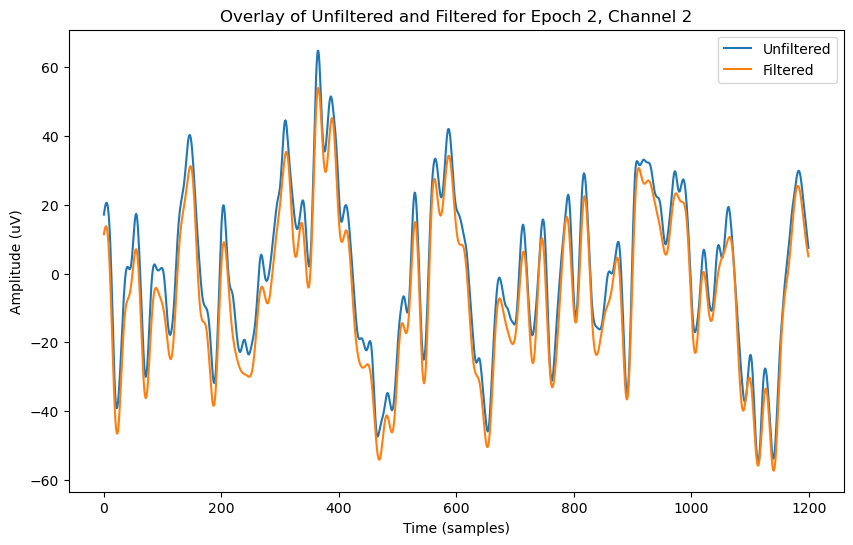

TypeError: cannot unpack non-iterable NoneType object

In [29]:
unfilt_eeg, filt_eeg = preprocessing_signals_plot(subject)